In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms

In [3]:
# weights = models.MobileNet_V3_Large_Weights.IMAGENET1K_V2
weights = models.EfficientNet_B3_Weights.IMAGENET1K_V1
# model = models.mobilenet_v3_large(weights)
transform = weights.transforms()
transform

ImageClassification(
    crop_size=[300]
    resize_size=[320]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [3]:
import numpy as np
from torch.utils.data import Dataset, DataLoader

# Assuming you have a dataset class that returns images as PIL Images
def compute_mean_std(dataset):
    loader = DataLoader(dataset, batch_size=1024, shuffle=False)
    mean = 0.0
    std = 0.0
    nb_samples = 0

    for data in loader:
        image = data
        batch_samples = image.size(0)
        image = image.view(batch_samples, image.size(1), -1)
        mean += image.mean(2).sum(0)
        std += image.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples

    return mean, std

In [4]:
target_shape = (224, 224)
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Resize(target_shape)]
)

train = torchvision.datasets.ImageFolder(
    "/mnt/data1/src/datasets/poi_train_val/train",
    transform=transform,
)
val = torchvision.datasets.ImageFolder(
    "/mnt/data1/src/datasets/poi_train_val/val",
    transform=transform,
)

In [5]:
from PIL import Image

class CustomData(Dataset):
    def __init__(self, data):
        self.data = data
        self.data_img = np.array(self.data.imgs)[:, 0]
        self.transform = self.data.transform

    def __getitem__(self, index):
        img = self.data_img[index]
        # print(img)
        img = Image.open(img)
        if self.transform:
            img = self.transform(img)
        return img.to("cuda:0")
    
    def __len__(self):
        return len(self.data)
    
train_dataset = CustomData(train)
val_dataset = CustomData(val)

In [6]:
train_dataset[0].shape

torch.Size([3, 224, 224])

In [7]:
# print(compute_mean_std(train_dataset))
print(compute_mean_std(val_dataset))

(tensor([0.4062, 0.3848, 0.3771], device='cuda:0'), tensor([0.1590, 0.1555, 0.1497], device='cuda:0'))


In [4]:
dummy_input = torch.randn(1,3,250,320)
output = transforms(dummy_input)
output.shape

torch.Size([1, 3, 224, 224])

In [5]:
transforms = models.EfficientNet_B3_Weights.IMAGENET1K_V1.transforms()
output = transforms(dummy_input)
output.shape

torch.Size([1, 3, 300, 300])

In [6]:
class TripletLoss(nn.Module):
    """
    hàm loss triplet
    """

    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.loss = nn.TripletMarginLoss(margin=margin, p=2, eps=1e-7)

    def forward(self, anchor, positive, negative, size_average=True):
        distance_positive = (anchor - positive).pow(2).sum(1)  # .pow(.5)
        distance_negative = (anchor - negative).pow(2).sum(1)  # .pow(.5)
        # distance_negative1 = (anchor - negative1).pow(2).sum(1)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        # losses = F.relu(distance_positive*2 - distance_negative - distance_negative1  + self.margin)
        # return self.loss(anchor, positive, negative)
        return losses.mean() if size_average else losses.sum()

In [9]:
class EmbeddingNet(nn.Module):
    def __init__(self, backbone):
        super(EmbeddingNet, self).__init__()
        self.convnet = nn.Sequential(*list(backbone.children())[:-1])
        self.fc = nn.Sequential(nn.Linear(960, 512, bias=True))

    def forward(self, x):
        flatten = self.convnet(x).flatten(start_dim=1)
        backbone = flatten.view(flatten.size()[0], -1)
        output = self.fc(backbone)
        # return torch.cat((output, output1),1)
        return output

    def get_embedding(self, x):
        return self.forward(x)

        # self.convnet = nn.Sequential(nn.Conv2d(1, 32, 5), nn.PReLU(),
        #                              nn.MaxPool2d(2, stride=2),
        #                              nn.Conv2d(32, 64, 5), nn.PReLU(),
        #                              nn.MaxPool2d(2, stride=2))

        # self.fc1 = nn.Sequential(nn.Linear(960, 512),
        #     nn.PReLU(),
        #     nn.Linear(512, 256),
        #     nn.PReLU(),
        #     nn.Linear(256, 256)
        # )
        # self.fc2 = nn.Sequential(nn.Linear(960, 512),
        #     nn.PReLU(),
        #     nn.Linear(512, 256),
        #     nn.PReLU(),
        #     nn.Linear(256, 128)
        # )


class EmbeddingNetL2(nn.Module):
    def __init__(self, backbone):
        super(EmbeddingNetL2, self).__init__()
        self.backbone = nn.Sequential(*list(backbone.children())[:-1])

    def forward(self, x):
        flatten = self.backbone(x).flatten(start_dim=1)
        output = flatten.view(flatten.size()[0], -1)
        return F.normalize(output, p=2, dim=1)

    def get_embedding(self, x):
        return self.forward(x)


# class ClassificationNet(nn.Module):
#     def __init__(self, embedding_net, n_classes):
#         super(ClassificationNet, self).__init__()
#         self.embedding_net = embedding_net
#         self.n_classes = n_classes
#         self.nonlinear = nn.PReLU()
#         self.fc1 = nn.Linear(256, n_classes)

#     def forward(self, x):
#         output = self.embedding_net(x)
#         output = self.nonlinear(output)
#         scores = F.log_softmax(self.fc1(output), dim=-1)
#         return scores

#     def get_embedding(self, x):
#         return self.nonlinear(self.embedding_net(x))


# class SiameseNet(nn.Module):
#     def __init__(self, embedding_net):
#         super(SiameseNet, self).__init__()
#         self.embedding_net = embedding_net

#     def forward(self, x1, x2):
#         output1 = self.embedding_net(x1)
#         output2 = self.embedding_net(x2)
#         return output1, output2

#     def get_embedding(self, x):
#         return self.embedding_net(x)


class TripletNet(nn.Module):
    def __init__(self, embedding_net):
        super(TripletNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2, x3):
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        output3 = self.embedding_net(x3)
        return output1, output2, output3

    def get_embedding(self, x):
        return self.embedding_net(x)

In [10]:
dummy_input = torch.rand(1, 3, 224, 224)
backbone = torchvision.models.mobilenet_v3_large(
    weights="MobileNet_V3_Large_Weights.IMAGENET1K_V2"
)
model = EmbeddingNetL2(backbone)
output = model(dummy_input)
output

tensor([[ 0.4592,  0.1400,  0.2700,  0.3473,  0.2941,  0.3369,  0.2400,  0.6330,
          0.3150,  0.4918,  0.2821,  0.2722,  0.1673,  0.3079,  0.7789,  0.1255,
          0.6041,  0.5709,  0.3501,  0.1664,  0.4615, -0.0825,  0.0566,  0.0689,
          0.5728,  0.2297,  0.2307,  0.1335,  0.2944,  0.2294,  0.3163,  0.4695,
          0.2363,  0.5743,  0.1219,  0.7875,  0.2053,  0.8206,  0.4734,  0.2734,
          0.2569,  0.3831,  0.2630,  0.2485,  0.1520,  0.2979,  0.2500,  0.2821,
          0.2143,  0.3213,  0.5778,  0.1793,  0.2454,  0.2402,  0.1385,  0.7129,
          0.5530,  0.5870,  0.5988,  0.3596,  0.4834,  0.3683,  0.1771,  0.4484,
          0.3485,  0.6261,  0.3297,  0.2144,  0.4923,  0.2773,  0.2352,  0.1465,
          0.5692,  0.8796,  0.1899,  0.1951,  0.6825,  0.0633,  0.4699,  0.2502,
          0.1978,  0.8112,  0.6643,  0.3157,  0.3452,  0.1965,  0.1365,  0.3001,
          0.3408,  0.0311,  0.3252,  0.9214,  0.4788,  0.2815,  0.7000,  0.3488,
          0.3742,  0.1751,  

In [ ]:
def train_epoch(train_loader, model, loss_fn, optimizer, cuda, log_interval, metrics):
    for metric in metrics:
        metric.reset()

    model.train()
    losses = []
    total_loss = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        target = target if len(target) > 0 else None
        if not type(data) in (tuple, list):
            data = (data,)
        if cuda:
            data = tuple(d.to("cuda") for d in data)
            if target is not None:
                target = target.to("cuda")

        optimizer.zero_grad()
        outputs = model(*data)

        if type(outputs) not in (tuple, list):
            outputs = (outputs,)

        loss_inputs = outputs
        if target is not None:
            target = (target,)
            loss_inputs += target

        loss_outputs = loss_fn(*loss_inputs)
        loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
        losses.append(loss.item())
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        for metric in metrics:
            metric(outputs, target, loss_outputs)

        if batch_idx % log_interval == 0:
            message = "Train: [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                batch_idx * len(data[0]),
                len(train_loader.dataset),
                100.0 * batch_idx / len(train_loader),
                np.mean(losses),
            )
            for metric in metrics:
                message += "\t{}: {}".format(metric.name(), metric.value())

            print(message)
            losses = []

    total_loss /= batch_idx + 1
    return total_loss, metrics


def test_epoch(val_loader, model, loss_fn, cuda, log_interval, metrics):
    with torch.no_grad():
        for metric in metrics:
            metric.reset()

        model.eval()
        val_loss = 0
        losses = []

        for batch_idx, (data, target) in enumerate(val_loader):
            target = target if len(target) > 0 else None
            if not type(data) in (tuple, list):
                data = (data,)
            if cuda:
                data = tuple(d.to("cuda") for d in data)
                if target is not None:
                    target = target.to("cuda")

            outputs = model(*data)
            if type(outputs) not in (tuple, list):
                outputs = (outputs,)
            loss_inputs = outputs
            if target is not None:
                target = (target,)
                loss_inputs += target

            loss_outputs = loss_fn(*loss_inputs)
            loss = (
                loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
            )
            val_loss += loss.item()
            losses.append(loss.item())

            for metric in metrics:
                metric(outputs, target, loss_outputs)

            if batch_idx % log_interval == 0:
                message = "Test: [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    batch_idx * len(data[0]),
                    len(val_loader.dataset),
                    100.0 * batch_idx / len(val_loader),
                    np.mean(losses),
                )
                for metric in metrics:
                    message += "\t{}: {}".format(metric.name(), metric.value())

                print(message)
                losses = []

    val_loss /= batch_idx + 1
    return val_loss, metrics

In [ ]:
def fit(
    train_loader,
    val_loader,
    model,
    loss_fn,
    optimizer,
    scheduler,
    n_epochs,
    cuda,
    log_interval,
    train_loss_history,
    val_loss_history,
    metrics=[],
    start_epoch=0,
    save_path=None,
):
    """
    Loaders, model, loss function and metrics should work together for a given task,
    i.e. The model should be able to process data output of loaders,
    loss function should process target output of loaders and outputs from the model

    Examples: Classification: batch loader, classification model, NLL loss, accuracy metric
    Siamese network: Siamese loader, siamese model, contrastive loss
    Online triplet learning: batch loader, embedding model, online triplet loss
    """
    for epoch in range(0, start_epoch):
        scheduler.step()

    for epoch in range(start_epoch, n_epochs):

        # Train stage
        train_loss, metrics = train_epoch(
            train_loader, model, loss_fn, optimizer, cuda, log_interval, metrics
        )
        train_loss_history.append(train_loss)
        scheduler.step()

        message = "Epoch: {}/{}. Train set: Average loss: {:.4f}".format(
            epoch + 1, n_epochs, train_loss
        )
        for metric in metrics:
            message += "\t{}: {}".format(metric.name(), metric.value())

        val_loss, metrics = test_epoch(
            val_loader, model, loss_fn, cuda, log_interval, metrics
        )
        val_loss_history.append(val_loss)

        message += "\nEpoch: {}/{}. Validation set: Average loss: {:.4f}".format(
            epoch + 1, n_epochs, val_loss
        )
        for metric in metrics:
            message += "\t{}: {}".format(metric.name(), metric.value())

        print(message)

        if save_path:
            torch.save(model, save_path)

    return train_loss_history, val_loss_history

In [ ]:
def eval(test_loader, model, loss_fn, cuda, log_interval, metrics=[]):

    message = ""
    test_loss, metrics = test_epoch(
        test_loader, model, loss_fn, cuda, log_interval, metrics
    )

    message += "\nTest set: Average loss: {:.4f}".format(test_loss)
    for metric in metrics:
        message += "\t{}: {}".format(metric.name(), metric.value())

    print(message)

In [ ]:
from torch.utils.data.dataset import Dataset
from torchvision import transforms

In [ ]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable
from PIL import Image

# from trainer import fit
import numpy as np

In [ ]:
import __main__

setattr(__main__, "TripletNet", TripletNet)

In [ ]:
def pre(img1, transform):
    img1 = Image.open(img1)
    img1 = transform(img1)
    return img1[None, :]

In [ ]:
class TripletData(Dataset):
    """
    Chọn random anchor + positive/negative
    """

    def __init__(self, data):
        self.data = data

        self.train = True
        self.transform = self.data.transform
        self.labels = np.array(self.data.imgs)[:, -1]
        self.data_img = np.array(self.data.imgs)[:, 0]

        self.labels_set = set(self.labels)
        self.label_to_indices = {
            label: np.where(self.labels == label)[0] for label in self.labels_set
        }

    def __getitem__(self, index):
        img1, label1 = self.data_img[index], self.labels[index].item()
        transform1 = transforms.Compose(
            [transforms.ToTensor(), transforms.Resize((224, 244))]
        )
        # vecotr1 = model_base.embedding_net(transform1(Image.open(img1))[None,:].to("cuda"))
        positive_index = index

        while positive_index == index:

            positive_index = np.random.choice(self.label_to_indices[label1])

        # negative_index = np.random.choice(self.label_to_indices[negative_label])

        while True:

            negative_label = np.random.choice(list(self.labels_set - set([label1])))

            negative_index = np.random.choice(self.label_to_indices[negative_label])
            img3 = self.data_img[negative_index]

            # vecotr2 = model_base.embedding_net(transform1(Image.open(img3))[None,:].to("cuda"))

            # if (vecotr1 - vecotr2).pow(2).sum(1) < 20:

            img2 = self.data_img[positive_index]
            # img3 = self.data_img[negative_index]

            img1 = Image.open(img1)
            img2 = Image.open(img2)
            img3 = Image.open(img3)

            if self.transform is not None:
                img1 = self.transform(img1)
                img2 = self.transform(img2)
                img3 = self.transform(img3)
                # img31 = self.transform(img31)
            return (img1, img2, img3), []

    def __len__(self):
        return len(self.data)

In [ ]:
print(f"Train/Val/Test length: {len(train)}, {len(val)}, {len(test)}")

In [ ]:
batch_size = 32

triplet_train_dataset = TripletData(train)
triplet_val_dataset = TripletData(val)
triplet_test_dataset = TripletData(test)

triplet_train_loader = torch.utils.data.DataLoader(
    triplet_train_dataset, batch_size=batch_size, shuffle=True
)
triplet_val_loader = torch.utils.data.DataLoader(
    triplet_val_dataset, batch_size=batch_size, shuffle=True
)
triplet_test_loader = torch.utils.data.DataLoader(
    triplet_test_dataset, batch_size=batch_size, shuffle=True
)

In [ ]:
for image, label in triplet_train_loader:
    input_data = image
    print(f"Input shape: {input_data[0].shape}")
    break

In [ ]:
backbone = torchvision.models.mobilenet_v3_large(
    weights="MobileNet_V3_Large_Weights.IMAGENET1K_V2"
)
backbone

In [ ]:
cuda = torch.cuda.is_available()
device = "cuda" if torch.cuda.is_available() else "cpu"

embedding_net = EmbeddingNetL2(backbone)
model = TripletNet(embedding_net).to(device)
model

In [ ]:
# input_data = tuple(d.to("cuda") for d in input_data)
# output_data = model(*input_data)
# print(f"Output shape: {output_data[0].shape}")

In [ ]:
margin = 2.0
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 40
log_interval = 200

save_path = "D:/Sugar/Triplet_Eff/mobile/model_40epochs_dim512_margin_2_v2.pth"

In [ ]:
train_loss_history, val_loss_history = [], []
with torch.autograd.set_detect_anomaly(True):
    fit(
        triplet_train_loader,
        triplet_val_loader,
        model,
        loss_fn,
        optimizer,
        scheduler,
        n_epochs,
        cuda,
        log_interval,
        train_loss_history,
        val_loss_history,
        save_path=save_path,
    )

In [4]:
import pickle
import matplotlib.pyplot as plt

history_path = (
    "/mnt/data1/src/sim/history/efficientnet_b3/history_160k_l2_hard_triplet_1.0.pkl"
)

with open(history_path, "rb") as f:
    history = pickle.load(f)

train_loss_history = history["train_loss"]
val_loss_history = history["val_loss"]

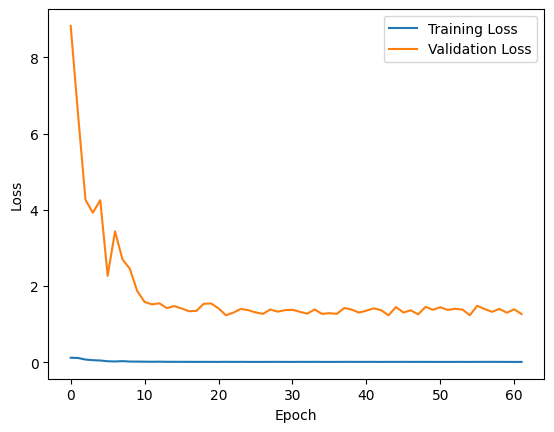

In [5]:
# Plot the loss history
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [6]:
print(train_loss_history[-1])
print(val_loss_history[-1])

0.010063260480062858
1.2655866923391954


# Test specific model

In [ ]:
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset

import torchvision
from torchvision import transforms

In [ ]:
class EmbeddingNet(nn.Module):
    def __init__(self, backbone):
        super(EmbeddingNet, self).__init__()
        self.convnet = nn.Sequential(*list(backbone.children())[:-1])

    def forward(self, x):
        output = self.convnet(x).flatten(start_dim=1)
        backbone = output.view(output.size()[0], -1)

        return backbone

    def get_embedding(self, x):
        return self.forward(x)


class TripletNet(nn.Module):
    def __init__(self, embedding_net):
        super(TripletNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2, x3):
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        output3 = self.embedding_net(x3)
        return output1, output2, output3

    def get_embedding(self, x):
        return self.embedding_net(x)

In [ ]:
import __main__

setattr(__main__, "TripletNet", TripletNet)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
load_path = "E:/DGM/BAIT/Sugar1/Triplet_Eff/eff/model_round3_100epochs_margin3.0.pth"

In [ ]:
trained_model = torch.load(load_path, map_location=torch.device(device))
trained_model

In [ ]:
def test_epoch(val_loader, model, loss_fn, cuda, log_interval, metrics):
    with torch.no_grad():
        for metric in metrics:
            metric.reset()

        model.eval()
        val_loss = 0
        losses = []

        for batch_idx, (data, target) in enumerate(val_loader):
            target = target if len(target) > 0 else None
            if not type(data) in (tuple, list):
                data = (data,)
            if cuda:
                data = tuple(d.to("cuda") for d in data)
                if target is not None:
                    target = target.to("cuda")

            outputs = model(*data)
            if type(outputs) not in (tuple, list):
                outputs = (outputs,)
            loss_inputs = outputs
            if target is not None:
                target = (target,)
                loss_inputs += target

            loss_outputs = loss_fn(*loss_inputs)
            loss = (
                loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
            )
            val_loss += loss.item()
            losses.append(loss.item())

            for metric in metrics:
                metric(outputs, target, loss_outputs)

            if batch_idx % log_interval == 0:
                message = "Test: [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    batch_idx * len(data[0]),
                    len(val_loader.dataset),
                    100.0 * batch_idx / len(val_loader),
                    np.mean(losses),
                )
                for metric in metrics:
                    message += "\t{}: {}".format(metric.name(), metric.value())

                print(message)
                losses = []

    val_loss /= batch_idx + 1
    return val_loss, metrics

In [ ]:
def eval(test_loader, model, loss_fn, cuda, log_interval, metrics=[]):

    message = ""
    test_loss, metrics = test_epoch(
        test_loader, model, loss_fn, cuda, log_interval, metrics
    )

    message += "\nTest set: Average loss: {:.4f}".format(test_loss)
    for metric in metrics:
        message += "\t{}: {}".format(metric.name(), metric.value())

    print(message)

In [ ]:
class TripletData(Dataset):
    """
    Chọn random anchor + positive/negative
    """

    def __init__(self, data):
        self.data = data

        self.train = True
        self.transform = self.data.transform
        self.labels = np.array(self.data.imgs)[:, -1]
        self.data_img = np.array(self.data.imgs)[:, 0]

        self.labels_set = set(self.labels)
        self.label_to_indices = {
            label: np.where(self.labels == label)[0] for label in self.labels_set
        }

    def __getitem__(self, index):
        img1, label1 = self.data_img[index], self.labels[index].item()
        positive_index = index

        while positive_index == index:
            if len(self.data_img) == 1:
                print("Folder has only one image, positive is the anchor itself TT")
                break

            positive_index = np.random.choice(self.label_to_indices[label1])

        img2 = self.data_img[positive_index]

        negative_label = np.random.choice(list(self.labels_set - set([label1])))
        negative_index = np.random.choice(self.label_to_indices[negative_label])

        img3 = self.data_img[negative_index]

        img1 = Image.open(img1)
        img2 = Image.open(img2)
        img3 = Image.open(img3)

        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            img3 = self.transform(img3)

        return (img1, img2, img3), []

    def __len__(self):
        return len(self.data)

In [ ]:
class TripletLoss(nn.Module):
    """
    hàm loss triplet
    """

    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.loss = nn.TripletMarginLoss(margin=margin, p=2, eps=1e-7)

    def forward(self, anchor, positive, negative, size_average=True):
        distance_positive = (anchor - positive).pow(2).sum(1)  # .pow(.5)
        distance_negative = (anchor - negative).pow(2).sum(1)  # .pow(.5)
        # distance_negative1 = (anchor - negative1).pow(2).sum(1)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        # losses = F.relu(distance_positive*2 - distance_negative - distance_negative1  + self.margin)
        # return self.loss(anchor, positive, negative)
        return losses.mean() if size_average else losses.sum()

In [ ]:
margin = 3.0
loss_fn = TripletLoss(margin)

In [ ]:
batch_size = 16
target_shape = (224, 224)
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(target_shape)])

test = torchvision.datasets.ImageFolder("E:/DGM/BAIT/Dataset/test", transform=transform)
triplet_test_dataset = TripletData(test)
triplet_test_loader = torch.utils.data.DataLoader(
    triplet_test_dataset, batch_size=batch_size, shuffle=False
)

In [ ]:
eval(triplet_test_loader, trained_model, loss_fn, False, log_interval=50)